In [28]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPS import IPS
from AdaIPS_v2 import AdaIPS_S
from getData import getData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of AdaIPS_v2 failed: Traceback (most recent call last):
  File "C:\Users\Ananth Sankar\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Ananth Sankar\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "C:\Users\Ananth Sankar\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "C:\Users\Ananth Sankar\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ananth Sankar\AppData\Roaming\Python\Python311\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "C:\Users\Ananth Sankar\AppData\Roami

In [29]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        
        self.t_losses = []
        self.v_losses = []
        

    def forward(self, x):
        x = x.view(-1, 28*28).float()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [30]:
epochs = 5
batch_size = 64


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainloader, trainset, testloader, testset, validationloader, valset = getData('MNIST', transform=transform, batch_size=batch_size)

TypeError: getData() got an unexpected keyword argument 'trasnform'

In [ ]:
def train(model, optimizer, epochs=2):
    print(optimizer)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer

    num_epochs = epochs
    for epoch in range(num_epochs):
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                return loss

    
            # if i % 100 == 0:                
            #     with torch.no_grad():
            #         for v_i, (v_inputs, v_labels) in enumerate(validationloader):
            #             v_inputs, v_labels = v_inputs.to(device), v_labels.to(device)
            #             v_outputs = model(v_inputs)
            #             v_loss = criterion(v_outputs, v_labels)
                    
            #         print("validation loss", v_loss.item())                   
            #     model.v_losses.append(v_loss.item())
                
            loss = optimizer.step(closure)
            
            if i % 100 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {loss}')
                model.t_losses.append(loss.item())
            

    print("Training complete.")
    return model

In [ ]:
def test(model):
    for i, (inputs, labels) in enumerate(testloader):
        output = model(inputs)
        output = output.argmax(axis=1)
        print(accuracy_score(labels, output.detach().numpy()))

In [ ]:
adaIpsModel = SimpleNN().to(device)
adaIpsOptimizer = AdaIPS_S(adaIpsModel.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99)
train(adaIpsModel, adaIpsOptimizer, epochs=epochs)

initialized optimizer with per layer learning rate update
AdaIPS_S (
Parameter Group 0
    T0: 3750.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.3143081665039062
Epoch 1, Step 100, Loss: 0.29497069120407104
Epoch 1, Step 200, Loss: 0.20709583163261414
Epoch 1, Step 300, Loss: 0.2467370629310608
Epoch 1, Step 400, Loss: 0.27034690976142883
Epoch 1, Step 500, Loss: 0.29817530512809753
Epoch 1, Step 600, Loss: 0.18121418356895447
Epoch 1, Step 700, Loss: 0.10493189096450806
Epoch 2, Step 0, Loss: 0.03999309241771698
Epoch 2, Step 100, Loss: 0.153312548995018
Epoch 2, Step 200, Loss: 0.0834808498620987
Epoch 2, Step 300, Loss: 0.08085398375988007
Epoch 2, Step 400, Loss: 0.06141611561179161
Epoch 2, Step 500, Loss: 0.19780230522155762
Epoch 2, Step 600, Loss: 0.1724993884563446
Epoch 2, Step 700, Loss: 0.17780208587646484
Epoch 3, Step 0, Loss: 0.1654433161020279
Epoch 3, Step 100, Loss: 0.2088196575641632
Epoch 3, Step 200, Loss: 0.232425

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
ipsModel = SimpleNN().to(device)
ipsOptimizer = IPS(ipsModel.parameters(), T=epochs * (len(trainset) / batch_size), lower_bound=0)
train(ipsModel, ipsOptimizer, epochs=5)

IPS (
Parameter Group 0
    T: 3750.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.2982289791107178
Epoch 1, Step 100, Loss: 0.7133796811103821
Epoch 1, Step 200, Loss: 0.430936336517334
Epoch 1, Step 300, Loss: 0.6411154866218567
Epoch 1, Step 400, Loss: 0.40313518047332764
Epoch 1, Step 500, Loss: 0.3773060441017151
Epoch 1, Step 600, Loss: 0.4769165813922882
Epoch 1, Step 700, Loss: 0.5237448811531067
Epoch 2, Step 0, Loss: 0.45478853583335876
Epoch 2, Step 100, Loss: 0.3047370910644531
Epoch 2, Step 200, Loss: 0.6208480596542358
Epoch 2, Step 300, Loss: 0.3365870416164398
Epoch 2, Step 400, Loss: 0.34637850522994995
Epoch 2, Step 500, Loss: 0.4366931915283203
Epoch 2, Step 600, Loss: 0.3666858673095703
Epoch 2, Step 700, Loss: 0.2732972204685211
Epoch 3, Step 0, Loss: 0.23232033848762512
Epoch 3, Step 100, Loss: 0.22833731770515442
Epoch 3, Step 200, Loss: 0.33748605847358704
Epoch 3, Step 300, Loss: 0.35182324051856995
Epoch 3, Step 400, Loss: 0.34752047061920166
Epoch 3, Step 50

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
adamModel = SimpleNN().to(device)
adamOptimizer = torch.optim.Adam(adamModel.parameters(), lr=1e-3)
train(adamModel, adamOptimizer, epochs=5)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epoch 1, Step 0, Loss: 2.303356170654297
Epoch 1, Step 100, Loss: 0.35738056898117065
Epoch 1, Step 200, Loss: 0.13244368135929108
Epoch 1, Step 300, Loss: 0.39337658882141113
Epoch 1, Step 400, Loss: 0.27882009744644165
Epoch 1, Step 500, Loss: 0.28161439299583435
Epoch 1, Step 600, Loss: 0.2912290692329407
Epoch 1, Step 700, Loss: 0.09009184688329697
Epoch 2, Step 0, Loss: 0.28991183638572693
Epoch 2, Step 100, Loss: 0.08101948350667953
Epoch 2, Step 200, Loss: 0.11839539557695389
Epoch 2, Step 300, Loss: 0.16728335618972778
Epoch 2, Step 400, Loss: 0.21899273991584778
Epoch 2, Step 500, Loss: 0.09120842814445496
Epoch 2, Step 600, Loss: 0.2752752900123596
Epoch 2, Step 700, Loss: 0.16063348948955536
Epoch 3, Step 0, Loss: 0.08526836335659027
Epoch 3, Step 100, Loss:

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
adaIpsModel_ = SimpleNN().to(device)
adaIpsOptimizer_ = AdaIPS_S(adaIpsModel_.parameters(), T=epochs * (len(trainset)/batch_size), lower_bound=0, beta_1=0.9, beta_2=0.99, per_param=True)
train(adaIpsModel_, adaIpsOptimizer_, epochs=epochs)

initialized optimizer with per layer learning rate update
AdaIPS_S (
Parameter Group 0
    T0: 3750.0
    beta_1: 0.9
    beta_2: 0.99
    eps: 1e-08
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 2.311267852783203
Epoch 1, Step 100, Loss: 0.3605019450187683
Epoch 1, Step 200, Loss: 0.1739388108253479
Epoch 1, Step 300, Loss: 0.46039140224456787
Epoch 1, Step 400, Loss: 0.4691874086856842
Epoch 1, Step 500, Loss: 0.4103061854839325
Epoch 1, Step 600, Loss: 0.16061462461948395
Epoch 1, Step 700, Loss: 0.06860888749361038
Epoch 2, Step 0, Loss: 0.14891886711120605
Epoch 2, Step 100, Loss: 0.3202495574951172
Epoch 2, Step 200, Loss: 0.11903611570596695
Epoch 2, Step 300, Loss: 0.25297287106513977
Epoch 2, Step 400, Loss: 0.10107818990945816
Epoch 2, Step 500, Loss: 0.12353243678808212
Epoch 2, Step 600, Loss: 0.12977337837219238
Epoch 2, Step 700, Loss: 0.18507039546966553
Epoch 3, Step 0, Loss: 0.09878962486982346
Epoch 3, Step 100, Loss: 0.22341719269752502
Epoch 3, Step 200, Loss: 0.30188

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
test(adaIpsModel)
# test(ipsModel)
test(adamModel)

0.9651
0.9717


In [ ]:
train(ipsModel, ipsOptimizer, epochs=2)

IPS (
Parameter Group 0
    T: 3750.0
    lower_bound: 0
)
Epoch 1, Step 0, Loss: 0.44709667563438416
Epoch 1, Step 100, Loss: 0.19722193479537964
Epoch 1, Step 200, Loss: 0.25696098804473877
Epoch 1, Step 300, Loss: 0.24803827702999115
Epoch 1, Step 400, Loss: 0.3192947208881378
Epoch 1, Step 500, Loss: 0.09445018321275711
Epoch 1, Step 600, Loss: 0.18000422418117523
Epoch 1, Step 700, Loss: 0.4514685571193695
Epoch 2, Step 0, Loss: 0.23202845454216003
Epoch 2, Step 100, Loss: 0.24114136397838593
Epoch 2, Step 200, Loss: 0.1831018626689911
Epoch 2, Step 300, Loss: 0.17006312310695648
Epoch 2, Step 400, Loss: 0.18878650665283203
Epoch 2, Step 500, Loss: 0.3335024416446686
Epoch 2, Step 600, Loss: 0.2601577043533325
Epoch 2, Step 700, Loss: 0.3122515082359314
Training complete.


SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
)

61
56
56


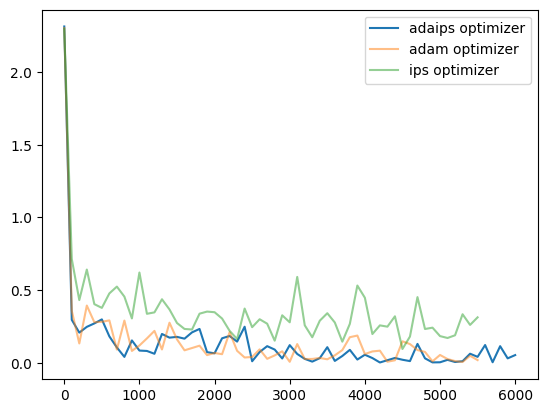

In [ ]:

models = [
    (adaIpsModel, 'adaips optimizer'),
    (adamModel, 'adam optimizer'),
    # (adaIpsModel_, 'adaips per param optimizer'),
    
    (ipsModel, 'ips optimizer')

]
exclude = []
focus = [adaIpsModel]
interval = 1
for model, optimizer in models:
    if model in exclude: continue
    print(len(model.t_losses))
    plt.plot(
        [i * 100 for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        [loss for i, loss in enumerate(model.t_losses) if i % interval == 0], 
        label=optimizer,
        alpha=0.5 if model not in focus else 1
    )

plt.legend()
plt.show()

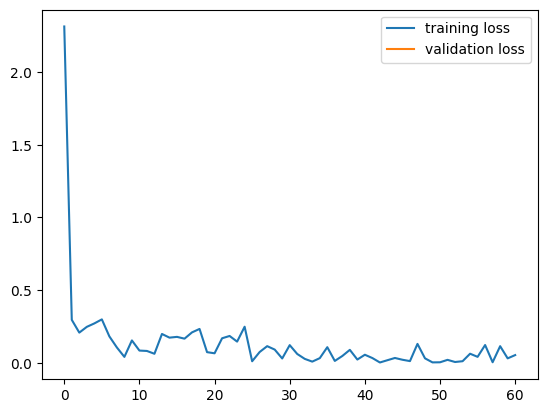

In [ ]:

plt.plot([t for t in adaIpsModel.t_losses], label='training loss')
plt.plot([v for v in adaIpsModel.v_losses], label='validation loss')
plt.legend()
plt.show()


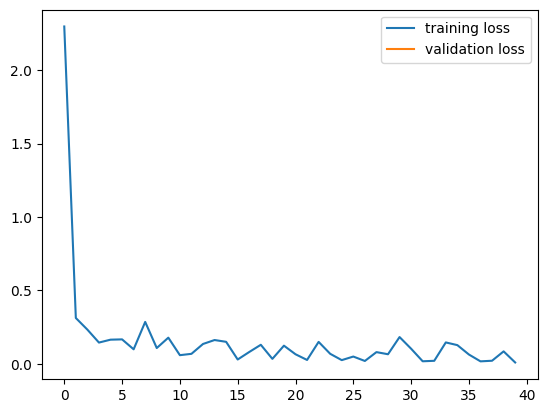

In [ ]:
plt.plot([t for t in adamModel.t_losses], label='training loss')
plt.plot([v for v in adamModel.v_losses], label='validation loss')
plt.legend()
plt.show()

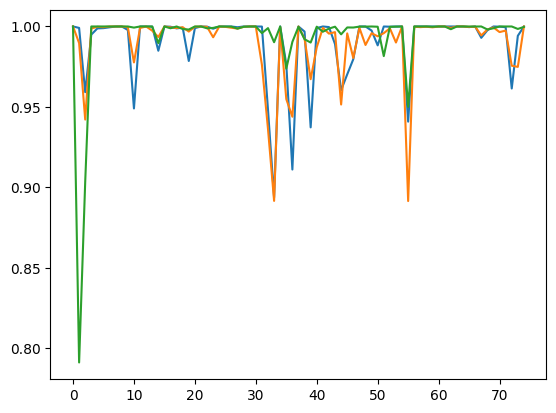

In [ ]:
plt.plot([s for i, s in enumerate(adaIpsOptimizer.step_sizes[0]) if i % 50 == 0])
plt.plot([s for i, s in enumerate(adaIpsOptimizer.step_sizes[2]) if i % 50 == 0])
plt.plot([s for i, s in enumerate(adaIpsOptimizer.step_sizes[4]) if i % 50 == 0])


plt.show()